항공사 고객 만족도 예측 경진대회

In [1]:
#@title
# 구글드라이브와 연동, csv파일 불러오기
from google.colab import drive
drive.mount('/content/gdrive/')

import os
original_dir = os.getcwd()

Mounted at /content/gdrive/


In [2]:
import pandas as pd
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Dacon/train.csv')
df.sample(5)

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,target
170,171,Female,Loyal Customer,48,Business travel,Eco Plus,978,3,1,1,1,2,3,3,2,2,3,2,3,2,3,34,19.0,1
1153,1154,Male,Loyal Customer,21,Personal Travel,Eco,1540,3,0,3,3,3,3,3,3,4,5,5,3,4,3,0,0.0,0
565,566,Male,Loyal Customer,10,Business travel,Business,4544,4,4,4,4,4,3,4,4,2,2,3,3,4,4,0,0.0,0
2243,2244,Male,Loyal Customer,38,Business travel,Business,875,5,5,5,5,3,4,4,4,4,4,4,5,4,5,0,0.0,1
480,481,Male,Loyal Customer,44,Personal Travel,Eco,2038,3,5,3,4,4,3,1,4,4,3,4,5,5,4,0,0.0,0


In [3]:
# trian dataset 분석
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 3000 non-null   int64  
 1   Gender                             3000 non-null   object 
 2   Customer Type                      3000 non-null   object 
 3   Age                                3000 non-null   int64  
 4   Type of Travel                     3000 non-null   object 
 5   Class                              3000 non-null   object 
 6   Flight Distance                    3000 non-null   int64  
 7   Seat comfort                       3000 non-null   int64  
 8   Departure/Arrival time convenient  3000 non-null   int64  
 9   Food and drink                     3000 non-null   int64  
 10  Gate location                      3000 non-null   int64  
 11  Inflight wifi service              3000 non-null   int64

In [4]:
df.describe()

,id,Age,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,target
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.00000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,39.203000,1983.079333,2.863333,3.009667,2.874333,3.016667,3.259667,3.352333,3.50500,3.488000,3.497000,3.485000,3.728667,3.370000,3.728667,3.356333,15.634333,15.922000,0.556000
std,866.169729,15.108802,1028.109117,1.394981,1.519543,1.431511,1.294713,1.322683,1.352826,1.31068,1.302211,1.283436,1.294218,1.154190,1.258158,1.161678,1.294057,45.083228,45.203411,0.496937
min,1.000000,7.000000,52.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.00000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,750.750000,27.000000,1348.250000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.00000,2.000000,3.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000
50%,1500.500000,39.000000,1937.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,0.000000,0.000000,1.000000
75%,2250.250000,51.000000,2547.250000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.00000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000,1.000000
max,3000.000000,80.000000,6882.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1128.000000,1115.000000,1.000000


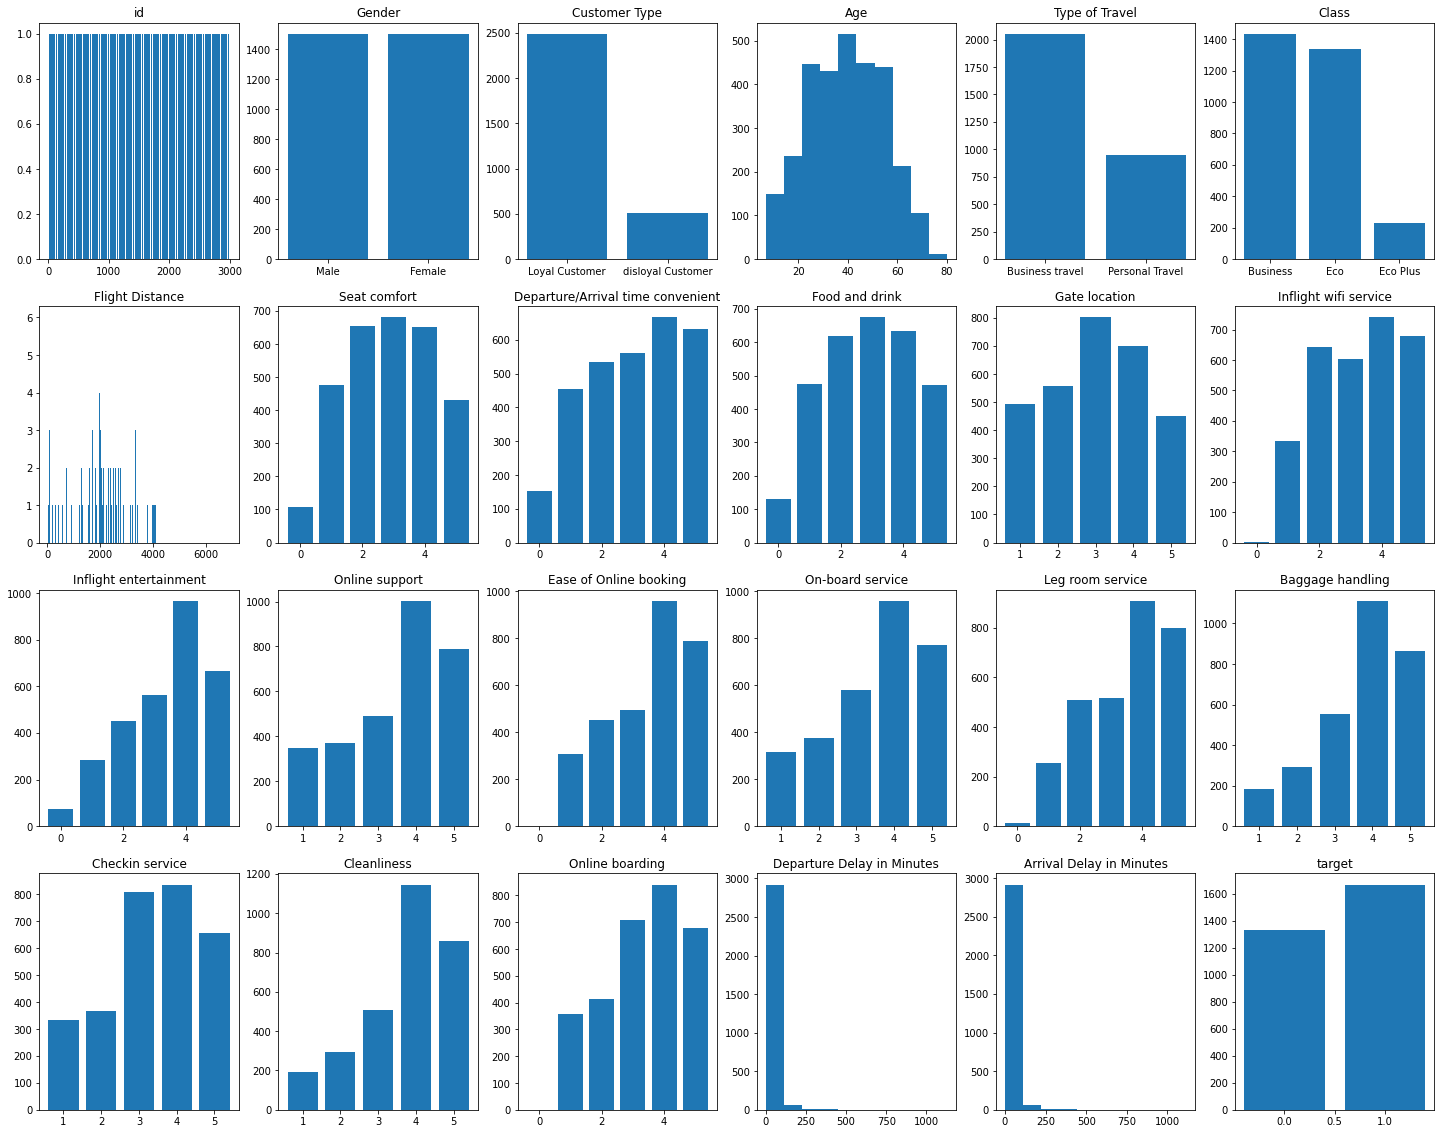

In [5]:
# 히스토그램으로 데이터 분포 확인
import matplotlib as mpl
import matplotlib.pyplot as plt

col = df.columns
fig, axes = plt.subplots(4, 6, figsize=(25,20))
axes = axes.flatten()

for i in range(24):
  temp_data = df[col[i]].value_counts()
  axes[i].set_title(col[i])
  if len(temp_data.unique()) > 10:
    axes[i].hist(df[col[i]])
  else:
    axes[i].bar(temp_data.keys(), temp_data.values)

plt.show()

<function matplotlib.pyplot.show>

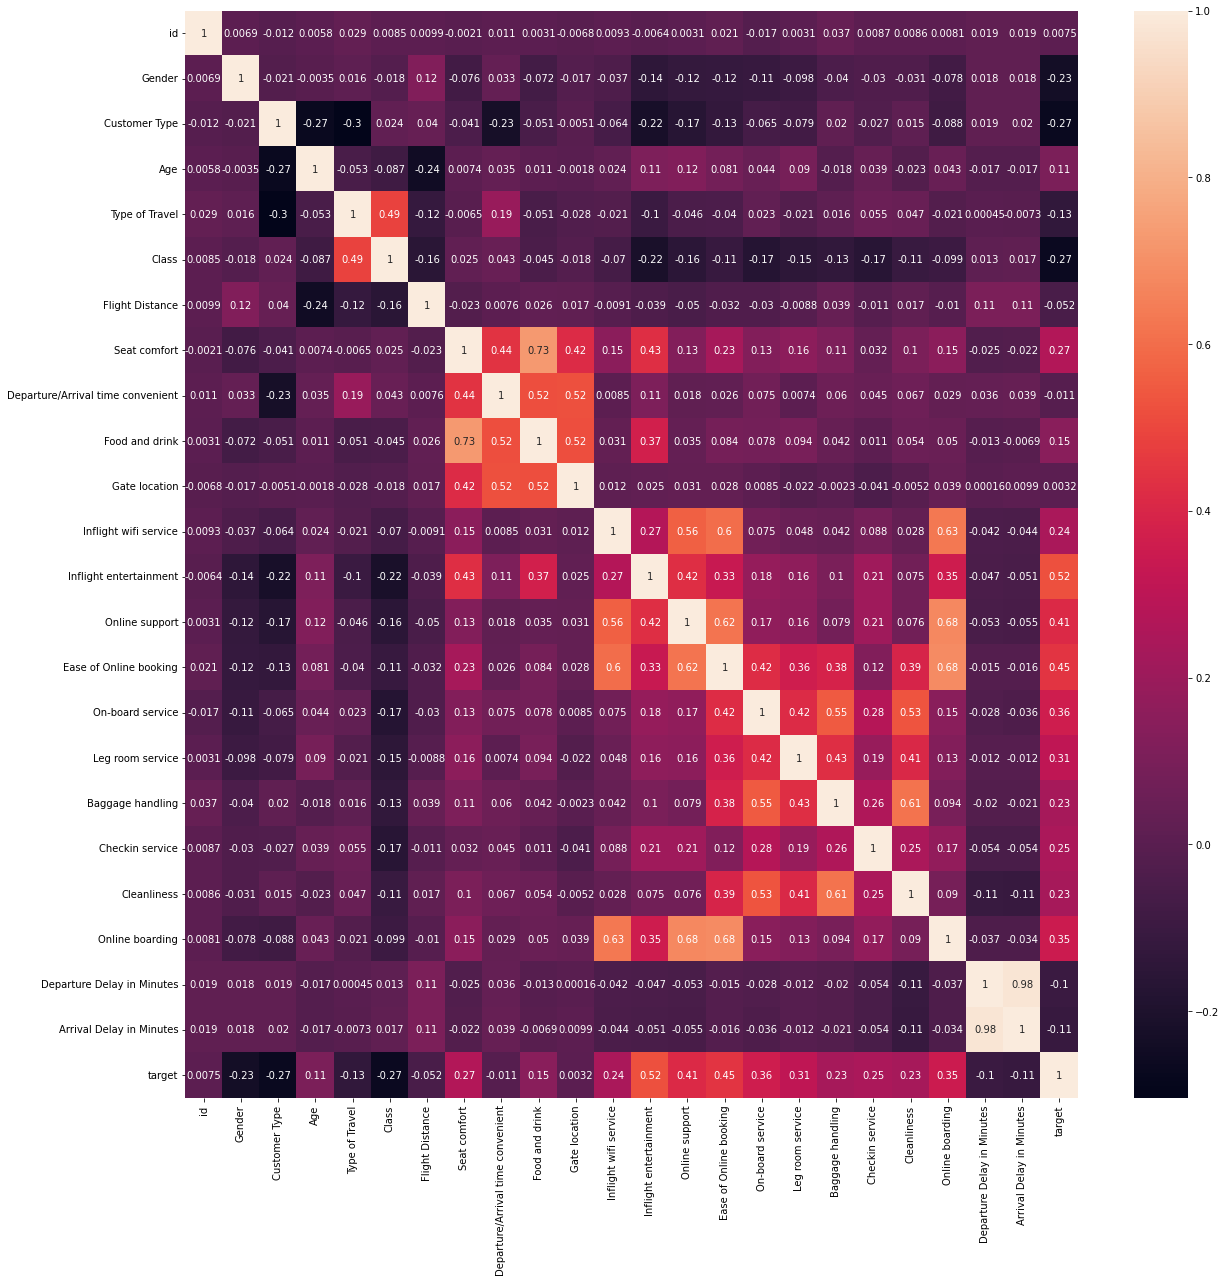

In [6]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

corr_df = df.copy()
corr_df[corr_df.columns[corr_df.dtypes=='O']] = corr_df[corr_df.columns[corr_df.dtypes=='O']].astype(str).apply(LabelEncoder().fit_transform)

fig, ax = plt.subplots(1,1 , figsize = (20,20))
sns.heatmap(corr_df.corr(), annot=True)
plt.show

In [2]:
# dataset 만들기
# 제출을 위한 테스트데이터 셋이 있으나 이것으로 테스트할 수는 없음 (target 없음) -> train_test_split

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.10.0+cu111].
device:[cuda:0].


* 데이터 전처리 : 필요없는 값 제거, onehot : 순서가 없을 때, 고유값 수 적을때, label : 순서가 의미가 있을 때
* 필요 없는 값 : id
* one-hot encoding : gender, type of travel
* label encoding : customer type, class

In [8]:
# 데이터 전처리 (데이터셋 만들기 전 전처리 연습)
df_data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Dacon/train.csv')
df_data = df_data.drop('id', axis=1)

# onehot encoding : gender, type of trave
# 
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             3000 non-null   object 
 1   Customer Type                      3000 non-null   object 
 2   Age                                3000 non-null   int64  
 3   Type of Travel                     3000 non-null   object 
 4   Class                              3000 non-null   object 
 5   Flight Distance                    3000 non-null   int64  
 6   Seat comfort                       3000 non-null   int64  
 7   Departure/Arrival time convenient  3000 non-null   int64  
 8   Food and drink                     3000 non-null   int64  
 9   Gate location                      3000 non-null   int64  
 10  Inflight wifi service              3000 non-null   int64  
 11  Inflight entertainment             3000 non-null   int64

In [9]:
print(df_data['Customer Type'].unique())
print(df_data['Type of Travel'].unique())
print(df_data['Class'].unique())

['disloyal Customer' 'Loyal Customer']
['Business travel' 'Personal Travel']
['Eco' 'Business' 'Eco Plus']


In [10]:
# label encoding
df_data['Customer Type'] = df_data['Customer Type'].map({'disloyal Customer' : 0, 'Loyal Customer' : 1})
df_data['Class'] = df_data['Class'].map({'Business' : 3, 'Eco Plus' : 2, 'Eco' : 1})

# one-hot encoding
df_data = pd.get_dummies(df_data, columns = ['Gender', 'Type of Travel'])
df_data.head(5)

,Customer Type,Age,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,target,Gender_Female,Gender_Male,Type of Travel_Business travel,Type of Travel_Personal Travel
0,0,22,1,1599,3,0,3,3,4,3,4,4,5,4,4,4,5,4,0,0.0,0,1,0,1,0
1,1,37,3,2810,2,4,4,4,1,4,3,5,5,4,2,1,5,2,18,18.0,0,1,0,1,0
2,1,46,3,2622,1,1,1,1,4,5,5,4,4,4,4,5,4,3,0,0.0,1,0,1,1,0
3,0,24,1,2348,3,3,3,3,3,3,3,3,2,4,5,3,4,3,10,2.0,0,1,0,1,0
4,1,58,3,105,3,3,3,3,4,4,5,4,4,4,4,4,4,5,0,0.0,1,1,0,1,0


In [11]:
pd.get_dummies(df_data['target'])

,0,1
0,1,0
1,1,0
2,0,1
3,1,0
4,0,1
...,...,...
2995,1,0
2996,1,0
2997,1,0
2998,1,0


In [12]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer Type                      3000 non-null   int64  
 1   Age                                3000 non-null   int64  
 2   Class                              3000 non-null   int64  
 3   Flight Distance                    3000 non-null   int64  
 4   Seat comfort                       3000 non-null   int64  
 5   Departure/Arrival time convenient  3000 non-null   int64  
 6   Food and drink                     3000 non-null   int64  
 7   Gate location                      3000 non-null   int64  
 8   Inflight wifi service              3000 non-null   int64  
 9   Inflight entertainment             3000 non-null   int64  
 10  Online support                     3000 non-null   int64  
 11  Ease of Online booking             3000 non-null   int64

In [9]:
class  PlaneDataset(Dataset):
  def __init__(self, df_data, train=True):
    self.train = train

    # 데이터 전처리
    self.df_data = df_data.drop('id', axis=1)
    self.df_data['Class'] = self.df_data['Class'].map({'Business' : 3, 'Eco Plus' : 2, 'Eco' : 1})
    self.df_data['Customer Type'] = self.df_data['Customer Type'].map({'disloyal Customer' : 0, 'Loyal Customer' : 1})
    self.df_data = pd.get_dummies(self.df_data, columns = ['Gender', 'Type of Travel'])

    if self.train:
      self.x = self.df_data.drop('target', axis=1)
      self.y = self.df_data['target']
      #self.y = pd.get_dummies(df_data['target'])
    else:
      self.x = self.df_data

  def __len__(self):
    return len(self.x)
  
  def __getitem__(self, idx):
      x = self.x.iloc[idx].values
      if self.train == False:
        return torch.tensor(x).float()
      y = self.y.iloc[idx]
      #y = self.y.iloc[idx].values
      return torch.tensor(x).float(), torch.tensor(y).float()



# 데이터 전처리
* 데이터 전처리하는 과정은 init에 넣기 : train, test data 각각 밖에서 전처리를 하고 dataset에 넣는것보다 dataset class에서 한번에 처리하는것이 간단.
* 전처리 내용
  * one-hot encoding -> pd.get_dummies()
    * pd.get_dummies(self.df_data, columns = ['Gender', 'Type of Travel']) : 여러 column에 대해 encoding, 나머지 column 그대로 남음
    * self.y = self.df_data['target'] 해당 column에 대해서만 encoding 나머지 column 출력 안함
  * y를 onehot encoding 한 이유 : cross entropy 사용하기 위해
  * label encoding -> df['column'].map({'a' : 1, 'b' : 2})
  * dataframe이라면 sklearn을 이용하는것보다 위의 방법이 간단한것 같다.

# x, y를 tensor로 변환하기
* torch.tensor 의 input값 : numpy, series 등등, dataframe은 안된다. 따라서 .values로 ndarray로 변환.
* .float()을 붙여주는 이유 : 정수 type의 tensor는 (아마도 backpropagation 등의 연산이 안되기 때문에) 오류가 뜬다. 따라서 변환해줘야 한다.
* to(device)는 어디에서 하는가? : train, test하는 부분에서 모델에 넣기 전 x, y를 to(device)

In [4]:
df_train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Dacon/train.csv')
df_test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Dacon/test.csv')
plane_data_train = PlaneDataset(df_train, train=True)
plane_data_test = PlaneDataset(df_test, train=False)

In [29]:
next(iter(plane_data_train)) # dataloader 가 아니라 실행할때마다 idx가 바뀌지 않음

(tensor([0.0000e+00, 2.2000e+01, 1.0000e+00, 1.5990e+03, 3.0000e+00, 0.0000e+00,
         3.0000e+00, 3.0000e+00, 4.0000e+00, 3.0000e+00, 4.0000e+00, 4.0000e+00,
         5.0000e+00, 4.0000e+00, 4.0000e+00, 4.0000e+00, 5.0000e+00, 4.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00]),
 tensor([1., 0.]))

In [5]:
dataloader_train = DataLoader(dataset=plane_data_train,
                              batch_size=128,
                              shuffle=True,
                              num_workers=2)

In [ ]:
features, labels = next(iter(dataloader_train))
print(f"x : {features}, x size : {features.shape}, x type : {type(features)}")
print(f"y : {labels}, y size : {labels.shape}, y type : {type(labels)}")

In [6]:
dataloader_test = DataLoader(dataset=plane_data_test,
                              batch_size=128,
                              shuffle=False,
                              num_workers=2)

In [33]:
features = next(iter(dataloader_test))
features.shape

torch.Size([128, 24])

In [13]:
# MLP 모델 생성
# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
class MLP(nn.Module):
    def __init__(self,name='mlp'):
        super(MLP,self).__init__()
        self.name = name
        self.lin_1 = nn.Linear(24, 32)
        self.lin_2 = nn.Linear(32, 16)
        self.lin_3 = nn.Linear(16, 2)
        self.dropout = nn.Dropout(p=0.2)
        self.init_param() # initialize parameters
        
    def init_param(self):
        nn.init.kaiming_normal_(self.lin_1.weight)
        nn.init.zeros_(self.lin_1.bias)
        nn.init.kaiming_normal_(self.lin_2.weight)
        nn.init.zeros_(self.lin_2.bias)
        nn.init.kaiming_normal_(self.lin_3.weight)
        nn.init.zeros_(self.lin_3.bias)


    def forward(self,x):
        x = F.relu(self.lin_1(x))
        x = self.dropout(x)
        x = F.relu(self.lin_2(x))
        x = self.dropout(x)
        x = self.lin_3(x)
        return x


mlp = MLP(name='mlp').to(device)
loss_fn = nn.CrossEntropyLoss()
optm = optim.Adam(mlp.parameters())
print (mlp)

MLP(
  (lin_1): Linear(in_features=24, out_features=32, bias=True)
  (lin_2): Linear(in_features=32, out_features=16, bias=True)
  (lin_3): Linear(in_features=16, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


# MLP model 생성하기
* layer : init에서 linear layer를 만들고 forward에서 연결해주는 느낌, forward에서 activation function을 섞어주면 된다.
* output : classification -> forward에서 정답값을 만드는것 아님 (backpropagation 때문인듯), 분류된 label값 (0 or 1)을 가지고 loss 계산하는 것이 아님. 따라서 분류되기 전 값을 return (0.xxx, 0.xxx)
* crossentropy 를 쓸려면 column이 label의 종류만큼 있어야한다.
* 최종적인 분류는 학습, 평가 부분에서 output값을 가공하여 처리
* 모델 class 만들고 객체를 만든 뒤 to(device) (모델과 모델 input값이 같은 device에 있어야됨)
* 모델 객체 만들고, loss function, optimizer 설정해준다.

In [14]:
# 학습
epochs = 20
for epoch in range(1, epochs+1):
  loss_val_sum = 0
  acc = 0
  num = 0
  for x,y in dataloader_train:
    x, y = x.to(device), y.to(device)
    output = mlp(x)
    _,pred = torch.max(output, 1)
    #print(pred.shape)
    #print(f"output : {output}")
    #print(f"pred : {pred}")
    #print(f"y : {y}")
    loss = loss_fn(output, y)
    _,labels = torch.max(y, 1)
    #print(labels.shape)
    acc += torch.sum(pred == labels)
    num += len(y)
    optm.zero_grad()
    loss.backward()
    optm.step()
    loss_val_sum += loss
  loss_val_avg = loss_val_sum / num
  acc_avg = acc / num
  if epoch % 2 == 0:
    print(f"epoch : {epoch}, acc : {acc_avg:.3f}, loss : {loss_val_avg:.3f}")

epoch : 2, acc : 0.508, loss : 1.340
epoch : 4, acc : 0.529, loss : 0.803
epoch : 6, acc : 0.520, loss : 0.467
epoch : 8, acc : 0.522, loss : 0.257
epoch : 10, acc : 0.523, loss : 0.151
epoch : 12, acc : 0.522, loss : 0.083
epoch : 14, acc : 0.499, loss : 0.040
epoch : 16, acc : 0.480, loss : 0.023
epoch : 18, acc : 0.491, loss : 0.013
epoch : 20, acc : 0.509, loss : 0.011


# 학습
* epoch마다 dataloaer에서 불러온 x,y(전체 데이터)에 대해 학습
* x, y 둘다 to(device) 하는 이유 : 다른 device에 있으면 같이 비교 불가능 ( x output값과 y 비교 불가)
* ~~y는 one-hot encoding 된  0,1 값 -> x도 비슷하게 만들어줘야 한다. -> torch.max(output, 1) 의 두번째 return값의 두번째 원소는 max index -> 이것을 통해 classification~~
* crossentropy를 사용하면 예측값 : (batch, class)의 shape, 정답값 : (batch,) 의 input을 받아야 한다. 또한 softmax가 포함되어있어 model에 softmax 등을 따로 넣어줄 필요가 없다.
* loss는 분류되기 전 값(output)을 통헤 계산되고, 정확도는 분류된 값(pred)를 통해 계산된다.
  * pred는 output값의 column중 높은값의 인덱스를 1로 반환
* y를 max를 통해 labels로 바꿔준 이유 : acc 계산하려면 column 수 같아야 쉽다. -> pred와 같은 방법으로 변환해준 것임
* loss, pred 계산시 비교하는 대상의 차원, dtype 같아야한다.
* pred 계산 -> loss, 정답 확인 -> optimizer gradient 계산 -> loss에 대해 backward -> optimizer.step으로 weight값 변경

In [22]:
# 테스트
result = np.array([])
for x in dataloader_test:
    x = x.to(device)
    with torch.no_grad():
      output = mlp(x)
    _,pred = torch.max(output, 1)
    pred = pred.cpu()
    result = np.concatenate((result, pred.squeeze().numpy()), axis=0)

submission = pd.DataFrame({'id': df_test['id'], 'target': result})
submission.to_csv('submission.csv', index=False)

# 테스트 (제출용)
* 제출을 위한것 -> dataloader에서 suffle false
* torch.no_grad() -> model 사용하는 부분만 해주기
* 나온 pred값은 gpu에 있음 -> .cpu()를 통해 cpu로 옮겨서 변환

# 후기
* cycle 한번을 체험해보기 위해 해본 것이므로 정확도는 별로 신경을 안썼음.
* sklearn으로 머신러닝 하면 간단할 것을 pytorch로 mlp 만들어서 하려고 하니 많이 복잡하다.
* pytorch는 생각보다 신경써야할게 많다. tensor의 dtpye shape device 등등
